In [1]:
# Automatically reload module
%load_ext autoreload
%autoreload 2

In [3]:
from nlp_analysis.word_wizard import WordWizard
from pipeline_executor import PipelineExecutor
from matplotlib import pyplot as plt

import pandas as pd

In [4]:
def plot_clusters(word_wizard: WordWizard, cmap='hsv_r'):

    result = pd.DataFrame(word_wizard.df['paragraph_reduced_dimensions_word_embeddings'].tolist(), columns=['x', 'y'])
    result['labels'] = word_wizard.df['paragraph_sentence_embeddings_clusters'].tolist()

    # remove x, y outliers using percentile
    x_min, x_max = result['x'].quantile([0.01, 0.99])
    y_min, y_max = result['y'].quantile([0.01, 0.99])
    result = result[(result['x'] > x_min) & (result['x'] < x_max)]
    result = result[(result['y'] > y_min) & (result['y'] < y_max)]

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap=cmap)

    plt.colorbar()

In [5]:
topic = 'Quantum Computing' # "quantumcomputing"AND"research"

# create a pipeline executor
pipeline_executor = PipelineExecutor()
df = pipeline_executor.execute(query=topic, max_articles=None, overwrite=False)

# print the first 5 rows of the dataframe
df.head(1)

,paragraph_index,engine,link,se_description,se_source,n3k_author,n3k_published,paragraph,title,body
0,0,Google,https://interestingengineering.com/science/a-n...,"In a groundbreaking study, scientists have dem...",Interesting Engineering,['Tejasri Gururaj'],2023-06-11 08:06:58+00:00,Both experiments were conducted at exceedingly...,Splitting phonons or sound for new type of qua...,Both experiments were conducted at exceedingly...


# Approach 1
## Topic Modelling with Embeddings
In this approach, we use the embeddings that we have already created. This approach is faster but might include more stopwords in the topics.

In [39]:
word_wizard = WordWizard(df)
word_wizard.create_sentence_embeddings()

Batches: 100%|██████████| 321/321 [00:57<00:00,  5.60it/s]


In [40]:
word_wizard.df.shape

(10245, 14)

In [36]:
word_wizard.cluster_embeddings(method='hdbscan')

word_wizard.df.shape

(10245, 14)

In [27]:
word_wizard.df['paragraph_sentence_embeddings_clusters'].value_counts()

0    30
3    25
2    24
1    10
4     6
5     5
Name: paragraph_sentence_embeddings_clusters, dtype: int64

In [38]:
col = 'paragraph_sentence_embeddings_clusters_medoids'
df = word_wizard.df
df[df[col] == True].shape

(10, 14)

In [32]:
word_wizard.reduce_demensionality()
word_wizard.df.head(1)

,paragraph_index,engine,link,se_description,se_source,n3k_author,n3k_published,paragraph,title,body,sentences,paragraph_sentence_embeddings,paragraph_sentence_embeddings_clusters,paragraph_sentence_embeddings_clusters_medoids,paragraph_reduced_dimensions_word_embeddings
0,0,Google,https://interestingengineering.com/science/a-n...,"In a groundbreaking study, scientists have dem...",Interesting Engineering,['Tejasri Gururaj'],2023-06-11 08:06:58+00:00,Both experiments were conducted at exceedingly...,Splitting phonons or sound for new type of qua...,Both experiments were conducted at exceedingly...,[Both experiments were conducted at exceedingl...,"[-0.09927327185869217, -0.038048699498176575, ...",11,False,"[14.44015884399414, 8.592035293579102]"


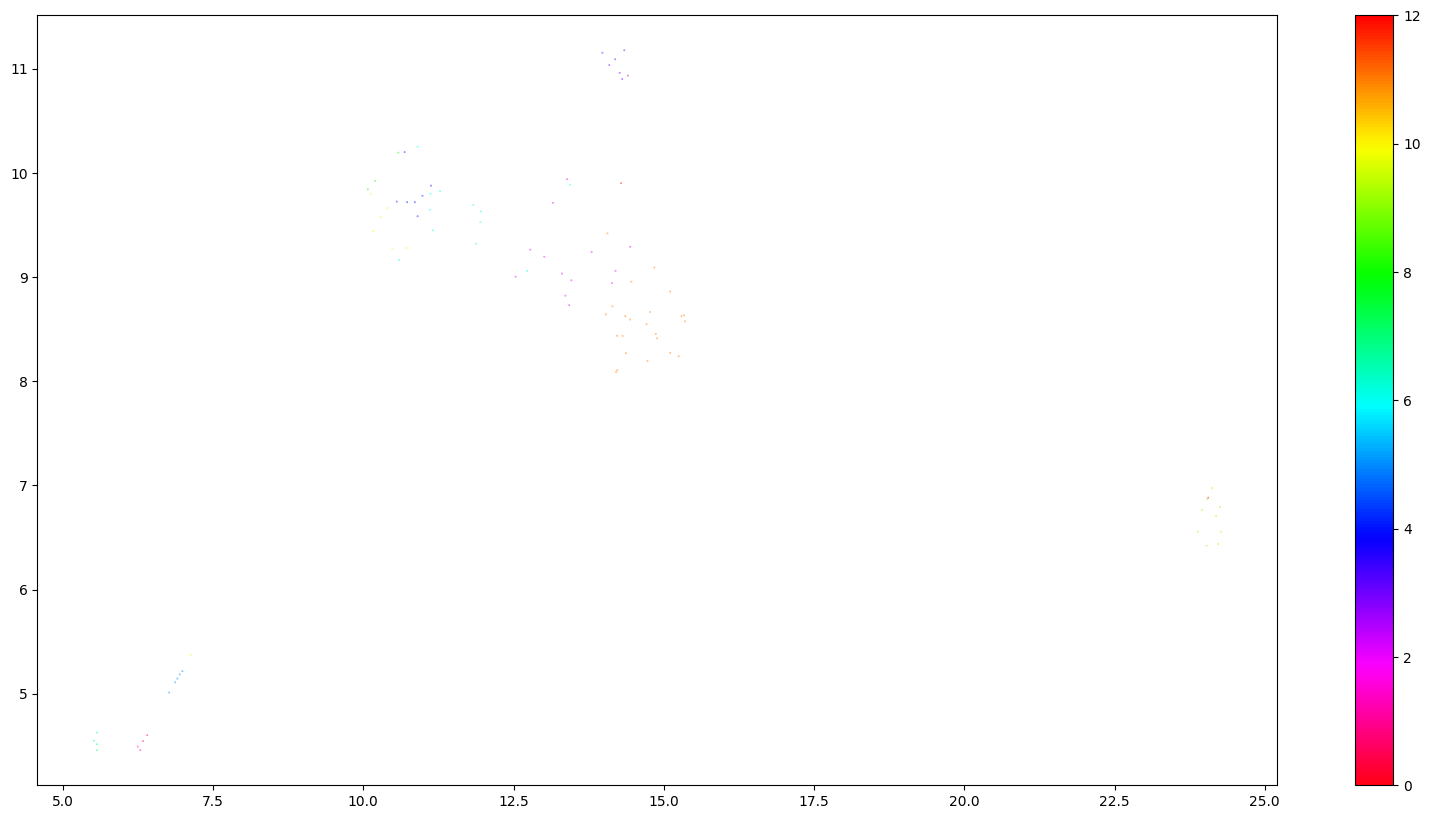

In [33]:
plot_clusters(word_wizard)

In [17]:
word_wizard.topic_modelling(n_words=5)

/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


In [19]:
word_wizard.df[['link', 'se_description', 'paragraph', 'title', 'topics']].to_csv('data/topic_modelling1.csv', index=False)

# Approach 2: 
## Using HDBScan
In this approach we do the clustering using HDBScan.

In [43]:
word_wizard = WordWizard(df)
word_wizard.create_sentence_embeddings()

Batches: 100%|██████████| 321/321 [00:56<00:00,  5.66it/s]


In [44]:
word_wizard.cluster_embeddings(column='paragraph', algorithm='hdbscan')

In [45]:
word_wizard.df.head(1)

,paragraph_index,engine,link,se_description,se_source,n3k_author,n3k_published,paragraph,title,body,sentences,paragraph_sentence_embeddings,paragraph_reduced_dimensions_word_embeddings,paragraph_sentence_embeddings_clusters
0,0,Google,https://interestingengineering.com/science/a-n...,"In a groundbreaking study, scientists have dem...",Interesting Engineering,['Tejasri Gururaj'],2023-06-11 08:06:58+00:00,Both experiments were conducted at exceedingly...,Splitting phonons or sound for new type of qua...,Both experiments were conducted at exceedingly...,[Both experiments were conducted at exceedingl...,"[-0.09927327185869217, -0.038048699498176575, ...","[2.179051399230957, 6.001199722290039]",30


In [46]:
word_wizard.df['paragraph_sentence_embeddings_clusters'].value_counts()

-1      2394
 200     133
 321     105
 159      87
 30       78
        ... 
 420       5
 345       5
 233       5
 452       5
 308       5
Name: paragraph_sentence_embeddings_clusters, Length: 456, dtype: int64

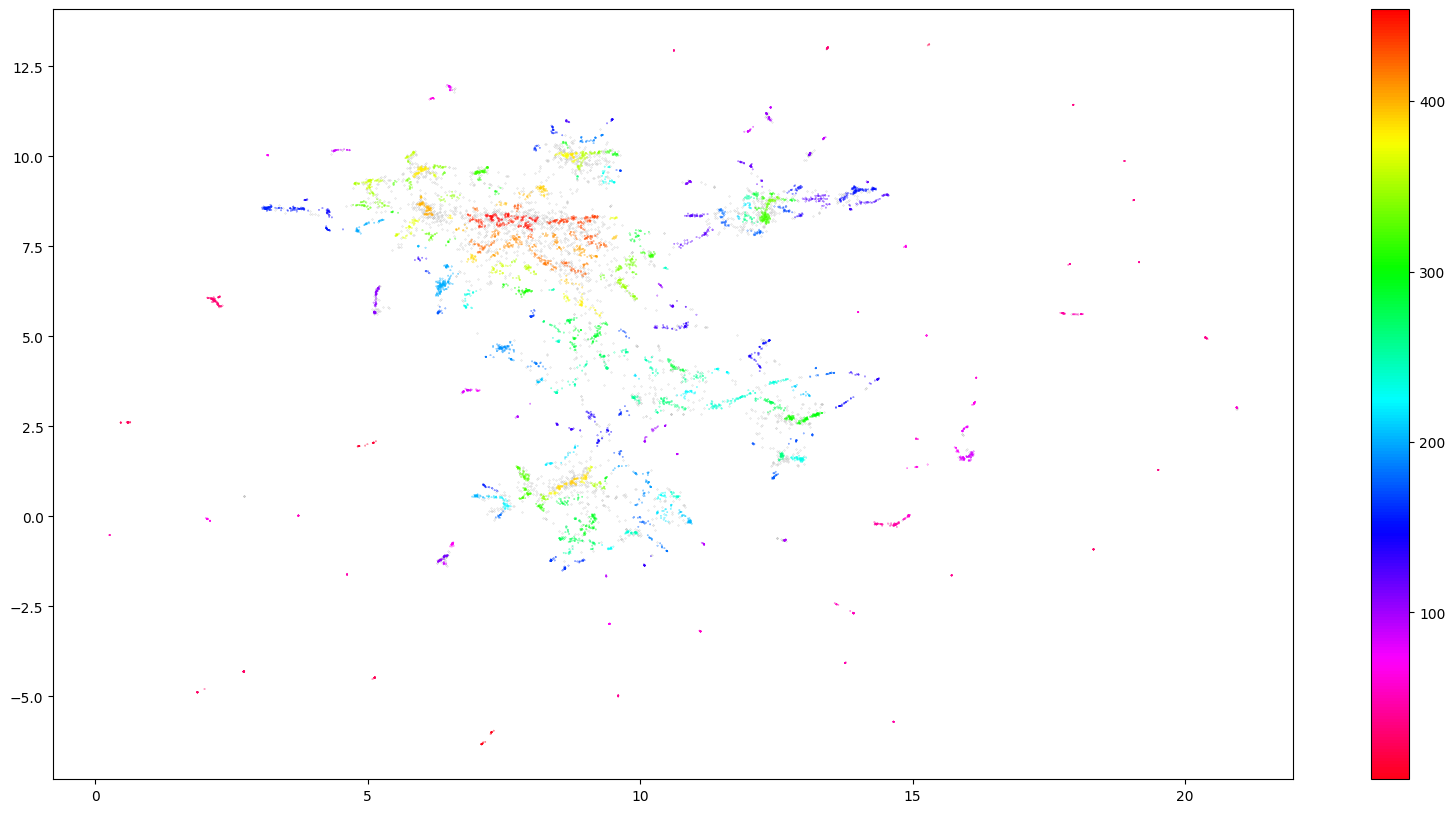

In [47]:
plot_clusters(word_wizard)

In [48]:
word_wizard.topic_modelling(column='paragraph', n_words=10)

/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


In [49]:
word_wizard.df[['link', 'se_description', 'paragraph', 'title', 'cluster_topics']].to_csv('data/topic_modelling3.csv', index=False)

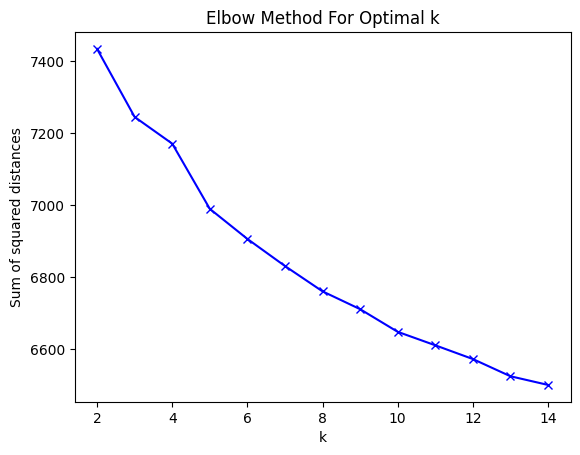

In [50]:
word_wizard.cluster_embeddings(column='paragraph', method='elbow')

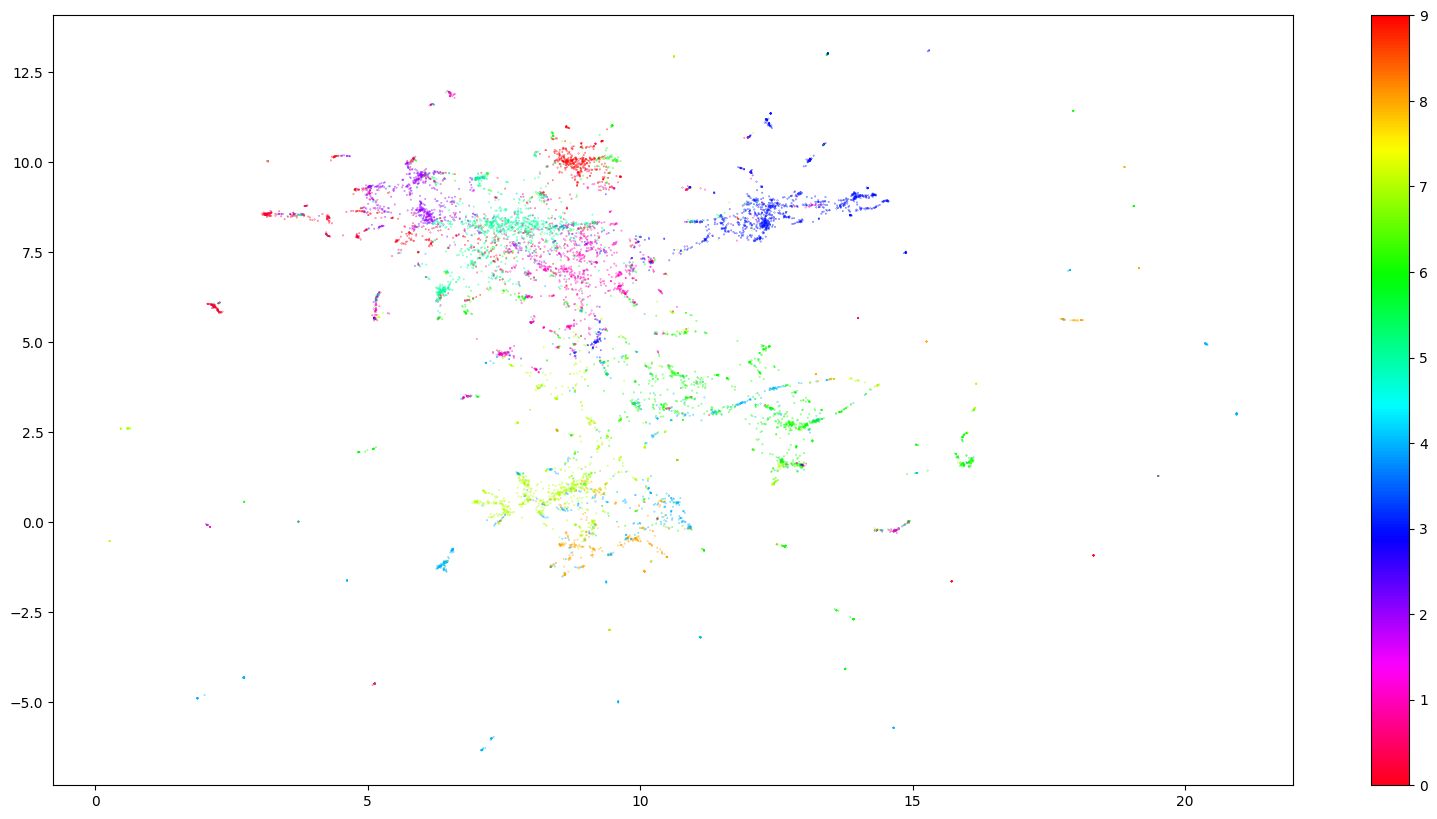

In [51]:
plot_clusters(word_wizard)

# Approach 3:
## Using K_Means Clustering with Silhouette Score

This approach is similar to the previous one but we use K_Means clustering instead of HDBScan and use Silhouette Score to find the optimal number of clusters.

In [52]:
word_wizard.cluster_embeddings(column='paragraph', algorithm='kmeans', method='silhouette')

In [62]:
word_wizard.topic_modelling(column='paragraph', n_words=20)

/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/quiquemz/.pyenv/versions/3.11.1/envs/capstone/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  warnings.warn(


In [64]:
word_wizard.df[['link', 'se_description', 'title', 'paragraph', 'topics']].to_csv('data/topic_modelling3.csv', index=False)

In [60]:
word_wizard.df['paragraph_sentence_embeddings_clusters'].value_counts()

0    5282
1    4963
Name: paragraph_sentence_embeddings_clusters, dtype: int64

In [61]:
word_wizard.df.head(1)

,paragraph_index,engine,link,se_description,se_source,n3k_author,n3k_published,paragraph,title,body,sentences,paragraph_sentence_embeddings,paragraph_reduced_dimensions_word_embeddings,paragraph_sentence_embeddings_clusters,cluster_topics_x,paragraph_sentence_embeddings_clusters_medoids,cluster_topics_y,topics
0,0,Google,https://interestingengineering.com/science/a-n...,"In a groundbreaking study, scientists have dem...",Interesting Engineering,['Tejasri Gururaj'],2023-06-11 08:06:58+00:00,Both experiments were conducted at exceedingly...,Splitting phonons or sound for new type of qua...,Both experiments were conducted at exceedingly...,[Both experiments were conducted at exceedingl...,"[-0.09927327185869217, -0.038048699498176575, ...","[2.179051399230957, 6.001199722290039]",0,"[(phonons, 0.10424061833148004), (phonon, 0.05...",False,"[(quantum computing, 0.012466223115008895), (c...","[(quantum computing, 0.012466223115008895), (c..."


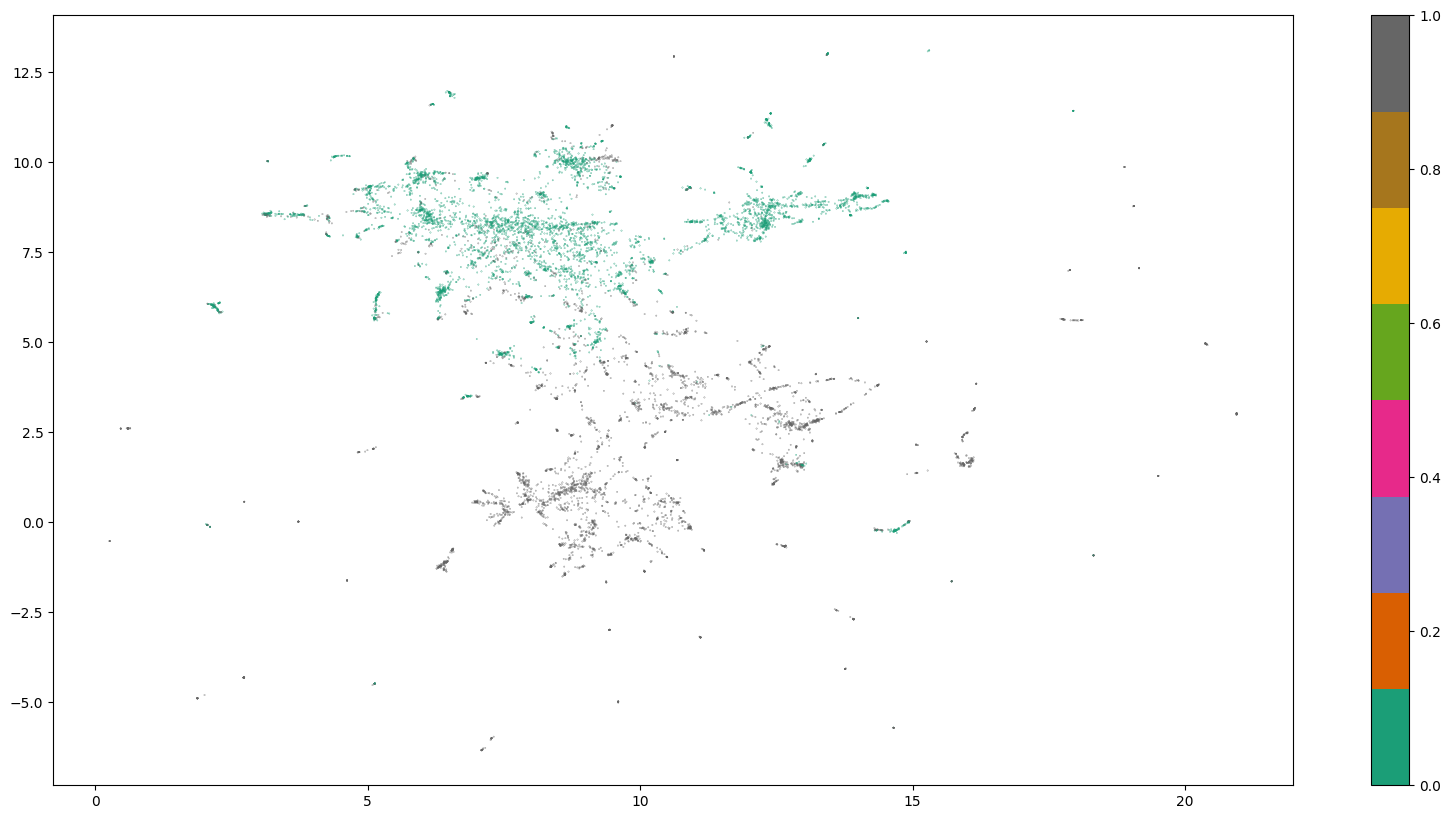

In [76]:
plot_clusters(word_wizard, 'Dark2')